# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = True
submission=False
batch_size=48
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='ResNext50'

HEIGHT = 137
WIDTH = 236
# FACTOR = 0.5
HEIGHT_NEW = 112
WIDTH_NEW = 112
# HEIGHT_NEW = int(HEIGHT*FACTOR)
# WIDTH_NEW = int(WIDTH*FACTOR)
print(WIDTH_NEW, HEIGHT_NEW)

112 112


In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
LR = 1e-4
WD = 1e-4
DP = 0.35
HDIM = 1024
outdir = Path('../res/{}_LR{}_WD{}_DP{}_IM{}-{}_bs{}_cgmaug_stepmix_4head-SPL-ft'.format(model_name, LR, WD, DP, HEIGHT_NEW, WIDTH_NEW,
                                                            batch_size))
trained_model_name = '/home/vemlr/Desktop/ResNext50_LR0.00025_WD0.0001_DP0.35_IM112-112_bs48_cgaug_4head/predictor_max_recall.pt'
TH = 20.0

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold-comb.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'comb_label']].values
n_comb_class = 1295
# class_map = dict(pd.read_csv('grapheme_1295.csv')[['grapheme','label']].values)
# comb_labels = np.array([class_map[itm] for ind, itm in train['grapheme'].items()]).reshape(-1,1)
# train_labels4 = np.hstack((train_labels, comb_labels))
# train['comb_label'] = comb_labels
# train.to_csv('train_with_fold-comb.csv')

In [10]:
a = np.random.rand(3,1)
print(np.shape(a))
# b = np.random.rand(3,4)
# print(a,b)
# c = np.hstack((a,b))
# print(c)
d = np.array([1,1])
print(np.shape(d))
d = d.reshape(-1,1)
print(np.shape(d))

(3, 1)
(2,)
(2, 1)


In [11]:
# print(class_map)

In [12]:
%%time
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 33.8 s, sys: 33 s, total: 1min 6s
Wall time: 7.65 s


In [13]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0  58]


In [14]:
#  import sys 

# # These are the usual ipython objects, including this one you are creating 
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# # Get a sorted list of the objects and their sizes 
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

<a id="dataset"></a>
# Dataset

In [15]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [16]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [17]:
# train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [18]:
# image, label = train_dataset_noaug[0]
# print('image', image.shape, 'label', label)

In [19]:
# print(image[:5,:5])
# print(20/255)

In [20]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i]
#     ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
#     ax.set_title(f'label: {label}')
# plt.tight_layout()
# plt.show()
# plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [21]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 10
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = image_size*0.075
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=TH/255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
#     xmin = xmin - 5 if (xmin > 5) else 0
#     ymin = ymin - 5 if (ymin > 5) else 0
#     xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
#     ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

# def crop_char_image_new(img0, threshold=TH/255., pad=10):
#     ymin,ymax,xmin,xmax = bbox(img0 > threshold)
#     #cropping may cut too much, so we need to add it back
# #     xmin = xmin - 13 if (xmin > 13) else 0
# #     ymin = ymin - 10 if (ymin > 10) else 0
# #     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
# #     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < 28./255.] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [(pad//2,), (pad//2,)], mode='constant')
#     return img

def resize(image, size=(WIDTH_NEW, HEIGHT_NEW)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

In [22]:
# nrow, ncol = 3, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[2]
#     if i ==0:
#         ax.imshow(image, cmap='Greys')
#     else:
#         ax.imshow(resize(crop_char_image_thin(affine_image(crop_char_image(image)))), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()
# # crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

In [23]:
# nrow, ncol = 3, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# PAD = 20
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[2]
#     if i ==0:
#         ax.imshow(image, cmap='Greys')
#     elif i==1:
#         ax.imshow(crop_char_image(image), cmap='Greys')
#     else:
#         ax.imshow(resize((affine_image(crop_char_image(image)))), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

In [24]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i]
#     ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

In [25]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i]
#     ax.imshow(resize((affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [26]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,IAAAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [27]:
affine_train_transform = Compose([
    OneOf([
        ShiftScaleRotate(scale_limit=.15, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT),
        IAAAffine(shear=20, mode='constant'),
        IAAPerspective(),
    ])
])

In [28]:
import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as AF

In [29]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=90, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = AF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [30]:
grid_mask_trans = Compose([
    albumentations.OneOf([
        GridMask(num_grid=(3,6), mode=0),
        GridMask(num_grid=(3,6), mode=1),
        GridMask(num_grid=(3,6), mode=2),
    ], p=1)
])

In [31]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)
        if self.affine:
            x = apply_aug(affine_train_transform, x)
            
#         if self.crop:
#             x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            
        h, w = x.shape

        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            r = np.random.uniform()
            if r < 0.2:
                x = apply_aug(A.CoarseDropout(max_holes=4, max_height=h//8, max_width=w//8, p=1.0), x)
            elif r < 0.4:
                x = apply_aug(A.Cutout(num_holes=1,  max_h_size=h//3, max_w_size=w//3, p=1.0),x)  # Deprecated...
            else:
                x = apply_aug(grid_mask_trans, x)
                
        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=10,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
            x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [32]:
# train_transform = Transform(
#     size=(image_size, image_size), 
#     sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.4,
#     grid_distortion_ratio=0.1, random_brightness_ratio=0.3,
#     piece_affine_ratio=0.2, ssr_ratio=0.2, elastic_distortion_ratio=0.3) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_transform = Transform(affine=True,
    crop=False, size=(WIDTH_NEW, HEIGHT_NEW), cutout_ratio=0.5) #threshold=20.,
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

In [33]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[3]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

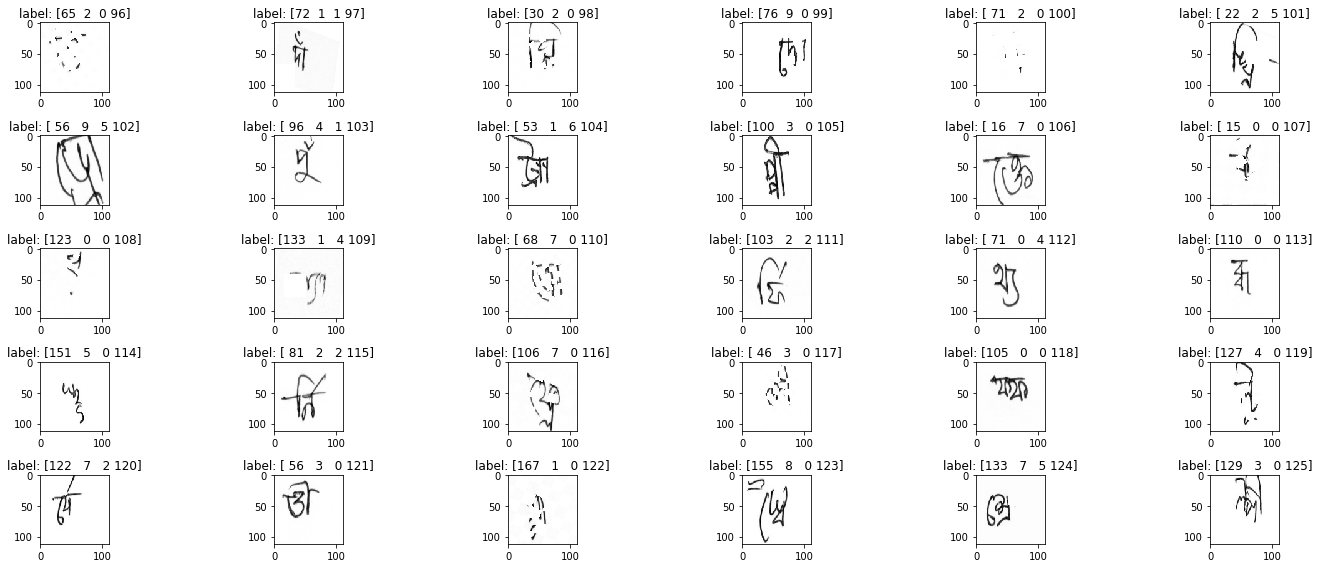

In [34]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i+100]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

In [35]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset_noaug[i+100]
#     ax.imshow(image, cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

In [36]:
# %reload_ext autoreload
# %autoreload 2

# from PIL import Image, ImageEnhance, ImageOps
# import numpy as np
# import matplotlib.pyplot as plt
# import math
# import random
# import pdb
# from autoaugment import ImageNetPolicy, CIFAR10Policy, SVHNPolicy, SubPolicy

In [37]:
# import PIL
# print("Using Pillow version {}. Upgrade using 'pip install Pillow -U'".format(PIL.__version__))

In [38]:
# class AutoTransform:
#     def __init__(self, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=TH,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., 
#                  piece_affine_ratio=0., auto_aug=False):
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.auto_policy = SVHNPolicy()
#         self.auto_aug = auto_aug

#     def __call__(self, example):
#         if self.train:
#             x, y = example
#         else:
#             x = example
            
#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
            
# #         if self.crop:
# #             x = crop_char_image_thin(x, threshold=self.threshold)

#         if self.size is not None:
#             x = resize(x, size=self.size)
            
#         x = np.transpose(np.stack((x, x, x), axis=0),(1,2,0))
        
#         if self.auto_aug:
#             x_int = Image.fromarray((x*255).astype(np.uint8))
#             x_int = self.auto_policy(x_int)
#             x = numpy.asarray(x_int).astype(np.float32) / 255.
        
#         if self.sigma > 0.:
#             x = add_gaussian_noise(x, sigma=self.sigma)

#         # albumentations...
#         x = x.astype(np.float32)
# #         assert x.ndim == 2
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             r = np.random.uniform()
#             if r < 0.5:
#                 x = apply_aug(A.CoarseDropout(max_holes=4, max_height=image_size//8, max_width=image_size//8, p=1.0), x)
#             else:
#                 x = apply_aug(A.Cutout(num_holes=1,  max_h_size=image_size//3, max_w_size=image_size//3, p=1.0),x)  # Deprecated...

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)


#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)


#         if self.normalize:
# #             x = (x.astype(np.float32) - 0.0692) / 0.2051  ##ORG
#             x = (x.astype(np.float32) - 0.449) / 0.226 ##Imagenet
# #         if x.ndim == 2:
# #             x = x[None, :, :]
#         x = x.astype(np.float32)
#         x = np.transpose(x,(2,0,1))
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x

In [39]:
# train_auto_transform = AutoTransform(auto_aug=True, crop=False,
#     size=(WIDTH_NEW, HEIGHT_NEW), cutout_ratio=0.5) #threshold=20.,
# train_auto_dataset = BengaliAIDataset(train_images[:200], train_labels,
#                                  transform=train_auto_transform)


In [40]:
# nrow, ncol = 5, 6

# fig, axes = plt.subpnrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_auto_dataset[i+100]
#     ax.imshow(np.transpose(image,(1,2,0)), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()lots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_auto_dataset[i+100]
#     ax.imshow(np.transpose(image,(1,2,0)), cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [41]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [42]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [43]:
a = np.array([2,3])
b = np.array([4,5,6])

In [44]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [45]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [46]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return (self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) 
                + ', ' + 'eps=' + str(self.eps) + ')')

In [47]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierNew(nn.Module):
    def __init__(self, inp = 2048, h1=1024, num_class = [1000,1,1], dropout_ratio=0.35):
        super().__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
        self.mp = nn.AdaptiveMaxPool2d(1)
        self.fla = Flatten()
#         self.bn0 = nn.BatchNorm1d(inp*2,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(dropout_ratio)
        
        self.logit = nn.ModuleList(
            [ nn.Linear(inp, c) for c in num_class]
        )
        self.gem = GeM()
#         self.fc1 = nn.Linear(inp*2, h1)
#         self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
#         self.dropout1 = nn.Dropout(dropout_ratio)
#         self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
#         ap = self.ap(x)
#         mp = self.mp(x)
#         x = torch.cat((ap,mp),dim=1)
        x = self.gem(x)
        x = self.fla(x)
#         x = self.bn0(x)
        x = self.dropout0(x)
        logit = [l(x) for l in self.logit]
#         x = F.relu(self.fc1(x))
#         x = self.bn1(x)
#         x = self.dropout1(x)         
#         x = self.fc2(x)
        return logit

In [48]:
# ap = nn.AdaptiveAvgPool2d((1,1))
# mp = nn.AdaptiveMaxPool2d((1,1))
# x = np.random.rand(5,4,4)
# print(x)
# print(ap)
# x1 = torch.nn.functional.adaptive_avg_pool2d(x, (1,1))
# print(x1)

In [49]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [50]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [51]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
import collections
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

from seresnext import *    

class PretrainedCNN(nn.Module):
    
    def load_pretrain(self, skip=['block0.','logit.'], is_print=True):
        load_pretrain(self, skip, pretrain_file=PRETRAIN_FILE, conversion=CONVERSION, is_print=is_print)
        
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, num_class=[10], use_bn=True,
                 pretrained='imagenet', dropout_ratio=0):
        super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
#         self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
# #         print(self.base_model)
#         names = []
#         for name, child in self.base_model.named_children():
#             names.append(name)
            
#         arch = self.base_model
#         arch = list(arch.children())
#         #saving the weights of the forst conv in w
#         w = arch[0][0].weight
#         #creating new Conv2d to accept 1 channel 
#         arch[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         #substituting weights of newly created Conv2d with w from but we have to take mean
#         #to go from  3 channel to 1
#         arch[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
#         arch = nn.Sequential(OrderedDict([(names[k], arch[k]) for k in range(len(names))]))
# #         print(arch)
#         self.base_model = arch
# #         print("#######################################")
# #         print(self.base_model)
#         activation = F.leaky_relu
#         self.do_pooling = True
#         if self.do_pooling:
#             inch = self.base_model.last_linear.in_features
#         else:
#             inch = None

        e = ResNext50()

        self.block0 = e.block0
        self.block1 = e.block1
        self.block2 = e.block2
        self.block3 = e.block3
        self.block4 = e.block4
        e = None  #dropped
        inch = 2048
        hdim = HDIM
        self.classifer = ClassifierNew(inp = inch, h1=hdim, num_class = num_class, dropout_ratio=dropout_ratio)
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
#         h = self.base_model.layer0(x)
#         h = self.base_model.layer1(h)
#         h = self.base_model.layer2(h)
#         h = self.base_model.layer3(h)
#         h = self.base_model.layer4(h) 

        batch_size,C,H,W = x.shape
        if (H,W) !=(HEIGHT_NEW, WIDTH_NEW):
            x = F.interpolate(x,size=(HEIGHT_NEW, WIDTH_NEW), mode='bilinear',align_corners=False)
            
        x = x.repeat(1,3,1,1)
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        h = self.classifer(x)

        return h

In [52]:
def print_base_layers(predictor):
    print("base model layer names::")
    for name, child in predictor.base_model.named_children():
        print(name)
        
def print_base_grad_status(predictor):
    print("base model grad status::")
    for name, child in predictor.base_model.named_children():
        print(name)
        for param in child.parameters():
            print(param.requires_grad)

In [53]:
# print_grad_status(predictortmp)

In [54]:
def frozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        if name in ['layer0','layer1','layer2','layer3']:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
        else:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True

In [55]:
def unfrozen_basiclayers(predictor):
    for name, child in predictor.base_model.named_children():
        for param in child.parameters():
            param.requires_grad = True

In [56]:
# frozen_basiclayers(predictortmp)
# print_grad_status(predictortmp)

In [57]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

n_total 186


In [58]:
# predictortmp = PretrainedCNN(in_channels=1, num_class=[n_grapheme, n_vowel, n_consonant], model_name=model_name, pretrained="imagenet")
# for name, child in predictortmp.named_children():
#     print(name)
# print_base_layers(predictortmp)

In [59]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-6)
#     lr_10 = max(learning_rate/10, 5e-6)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_100),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=lr_10),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=lr_10),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [60]:
# def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
#     base_params = list(map(id, classifier.predictor.base_model.parameters()))
#     fast_learned_params = filter(lambda p: id(p) not in base_params, 
#                                  classifier.parameters())
# #     print("base_params len:", len(base_params))
# #     print("fast_learned_params len:", len(list(fast_learned_params)))
#     lr_100 = max(learning_rate/100, 1e-7)
#     lr_10 = max(learning_rate/10, 1e-7)
#     optimizer = torch.optim.Adam(
#     [
#         dict(params=classifier.predictor.base_model.layer0.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer1.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer2.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer3.parameters(), lr=lr_10),
#         dict(params=classifier.predictor.base_model.layer4.parameters(), lr=learning_rate),        
#         dict(params=classifier.predictor.base_model.avg_pool.parameters(), lr=learning_rate),
#         dict(params=classifier.predictor.base_model.last_linear.parameters(), lr=learning_rate),
#         {'params': fast_learned_params},
#     ], lr = learning_rate, weight_decay=weight_decay)
    
#     return optimizer

In [61]:
def get_optimizer_adam(classifier, learning_rate=1e-3, weight_decay=0.0):
    
    base_params = list(map(id, classifier.predictor.parameters()))
    fast_learned_params = filter(lambda p: id(p) not in base_params, 
                                 classifier.parameters())
#     print("base_params len:", len(base_params))
#     print("fast_learned_params len:", len(list(fast_learned_params)))
    lr_100 = max(learning_rate/100, 1e-7)
    lr_10 = max(learning_rate/10, 1e-7)
    optimizer = torch.optim.Adam(
    [
        dict(params=classifier.predictor.block0.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block1.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block2.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block3.parameters(), lr=lr_10),
        dict(params=classifier.predictor.block4.parameters(), lr=learning_rate),
        {'params': fast_learned_params},
    ], lr = learning_rate, weight_decay=weight_decay)
    
    return optimizer

## Classifier

In [62]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, y, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = y[:,0][indices]
    shuffled_targets2 = y[:,1][indices]
    shuffled_targets3 = y[:,2][indices]
    shuffled_targets4 = y[:,3][indices]
    
    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [y[:,0], shuffled_targets1, y[:,1], shuffled_targets2, y[:,2], shuffled_targets3, 
               y[:,3], shuffled_targets4, lam]
    return data, targets

def mixup(data, y, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = y[:,0][indices]
    shuffled_targets2 = y[:,1][indices]
    shuffled_targets3 = y[:,2][indices]
    shuffled_targets4 = y[:,3][indices]
    
    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [y[:,0], shuffled_targets1, y[:,1], shuffled_targets2, y[:,2], shuffled_targets3, 
               y[:,3], shuffled_targets4, lam]
    return data, targets

In [63]:
def cross_entropy_spl(pred, target, k):
    loss = F.cross_entropy(pred, target, reduce = False)
    loss, _ = loss.topk(k)
    loss = loss.mean()
    return loss

In [64]:
def cutmix_criterion_spl(pred, targets, k):
    preds = pred
    targets1, targets2,targets3, targets4, targets5, targets6 = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5]
    targets7, targets8, lam = targets[6], targets[7], targets[8]
#     criterion = nn.CrossEntropyLoss(reduction='mean')
#     criterion = cross_entropy_spl
    return (2*(lam * cross_entropy_spl(preds[0], targets1, k) + (1 - lam) * cross_entropy_spl(preds[0], targets2, k)), 
            lam * cross_entropy_spl(preds[1], targets3, k) + (1 - lam) * cross_entropy_spl(preds[1], targets4, k),
            lam * cross_entropy_spl(preds[2], targets5, k) + (1 - lam) * cross_entropy_spl(preds[2], targets6, k),
            0.1*(lam * cross_entropy_spl(preds[3], targets7, k) + (1 - lam) * cross_entropy_spl(preds[3], targets8, k)))

def mixup_criterion_spl(pred, targets, k):
    preds = pred
    targets1, targets2,targets3, targets4, targets5, targets6 = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5]
    targets7, targets8, lam = targets[6], targets[7], targets[8]
#     criterion = nn.CrossEntropyLoss(reduction='mean')
#     criterion = cross_entropy_spl
    return (2*(lam * cross_entropy_spl(preds[0], targets1, k) + (1 - lam) * cross_entropy_spl(preds[0], targets2, k)),
           lam * cross_entropy_spl(preds[1], targets3, k) + (1 - lam) * cross_entropy_spl(preds[1], targets4, k),
           lam * cross_entropy_spl(preds[2], targets5, k) + (1 - lam) * cross_entropy_spl(preds[2], targets6, k),
           0.1*(lam * cross_entropy_spl(preds[3], targets7, k) + (1 - lam) * cross_entropy_spl(preds[3], targets8, k)))

In [65]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc

def criterion_spl(pred, target, k = batch_size):
    loss_grapheme = 2*cross_entropy_spl(pred[0], target[:, 0], k)
    loss_vowel = cross_entropy_spl(pred[1], target[:, 1], k)
    loss_consonant = cross_entropy_spl(pred[2], target[:, 2], k)
    loss_comb = 0.1*cross_entropy_spl(pred[3], target[:, 3], k)
    return loss_grapheme, loss_vowel, loss_consonant, loss_comb

def criterion(pred, target):
    loss_grapheme = 2*F.cross_entropy(pred[0], target[:, 0])
    loss_vowel = F.cross_entropy(pred[1], target[:, 1])
    loss_consonant = F.cross_entropy(pred[2], target[:, 2])
    loss_comb = 0.1*F.cross_entropy(pred[3], target[:, 3])
    return loss_grapheme, loss_vowel, loss_consonant, loss_comb


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant', 'loss_comb',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'acc_comb']

    def forward(self, x, y=None, train=True, k = batch_size, mix_ratio = 0.0):
        
        if train and np.random.rand()<mix_ratio:
            if np.random.rand()<0.3:
                x, targets = mixup(x, y, 0.2)
                pred = self.predictor(x)
                loss_grapheme, loss_vowel, loss_consonant, loss_comb = mixup_criterion_spl(pred, targets, k) 
            else:
                r = 0.8 + np.random.rand()/5
                x, targets = cutmix(x, y, r)
                pred = self.predictor(x)
                loss_grapheme, loss_vowel, loss_consonant, loss_comb = cutmix_criterion_spl(pred, targets, k)
        else:
            pred = self.predictor(x)
            loss_grapheme, loss_vowel, loss_consonant, loss_comb = criterion(pred, y)
        
        loss = loss_grapheme + loss_vowel + loss_consonant + loss_comb
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'loss_comb': loss_comb.item(),
            'acc_grapheme': accuracy(pred[0], y[:, 0]),
            'acc_vowel': accuracy(pred[1], y[:, 1]),
            'acc_consonant': accuracy(pred[2], y[:, 2]),
            'acc_comb': accuracy(pred[3], y[:, 3]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [66]:
# classifiertmp = BengaliClassifier(predictortmp).to(device)
# # for name, child in classifiertmp.named_children():
# #     print(name)
# # optimizertmp = get_optimizer_adam(classifiertmp)
# # print(optimizertmp)

# ctmp_params = list(map(id, classifiertmp.parameters()))
# print(len(ctmp_params))

# pbtmp_params = list(map(id, predictortmp.base_model.parameters()))
# print(len(pbtmp_params))

# pcftmp_params = list(map(id, predictortmp.classifer.parameters()))
# print(len(pcftmp_params))

# opt_tmp = get_optimizer_adam(classifiertmp)
# print(opt_tmp)

<a id="train"></a>
# Training code


In [67]:
# --- Model ---
device = torch.device(device)

def schedule_lr(metrics):
    avg_mae = metrics['recall']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[-1]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

## prepare data

In [68]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [69]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [70]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [71]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7, n_comb_class = 1295):
    if not isinstance(pred_y, list):
        pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(y[:, 0], pred_labels[0],average='macro')
    recall_vowel = sklearn.metrics.recall_score(y[:, 1], pred_labels[1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(y[:, 2], pred_labels[2], average='macro')
    recall_comb = sklearn.metrics.recall_score(y[:, 3], pred_labels[3], average='macro')    
    scores = [recall_grapheme, recall_vowel, recall_consonant, recall_comb]
    final_score = np.average(scores, weights=[2, 1, 1, 0])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [72]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant','loss_comb',
            'acc_grapheme', 'acc_vowel', 'acc_consonant','acc_comb', 'recall']

In [73]:
def lin_gen_k(epoch, n_epochs, batchsize):
    k = batchsize - int(epoch*batchsize/n_epochs)
    return max(1,k)

In [74]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        lin_k = lin_gen_k(epoch, n_epochs, n_sub)
        loss, metrics, pred_y = classifier(img_batch, regr_batch, train=True, k = lin_k, mix_ratio = epoch/n_epochs)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    return metrics_total, n_train_call

In [75]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch, train=False, k = n_sub, mix_ratio = 0.0)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
        
        schedule_lr(metrics_total)   
        return metrics_total


## Train


In [76]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [77]:
def save_params(outdir, k, img_h, img_w, th, arch, batchsize):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_w': img_w,
               'image_h': img_h,
               'threshold': th, 
               'batch_size':batchsize,
               'arch': arch, 
               'model_name': model_name,
               'learning_rate': LR,
               'weight_decay': WD,
               'dropout_ratio': DP,
               'hidden_dim':HDIM
              }
             )

In [78]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [79]:
import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 5
checkpt = 'm-checkpoint.pth.tar'
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, num_class=[n_grapheme, n_vowel, n_consonant, n_comb_class], 
                              model_name=model_name, pretrained="imagenet", dropout_ratio=DP)
#     predictor.load_pretrain(is_print=False)
    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    predictor.load_state_dict(torch.load(trained_model_name))
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)
    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=LR, weight_decay=WD)
#     optimizer = get_optimizer_adam(classifier, learning_rate=LR, weight_decay=WD)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.7, patience=5, min_lr=1e-7)


    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, HEIGHT_NEW, WIDTH_NEW, TH, arch, batch_size)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=False, size=(WIDTH_NEW, HEIGHT_NEW)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>
val_indexes: [9, 12, 20, 44, 48]
train_indexes: [0, 1, 2, 3, 4]


 20%|██        | 1/5 [00:00<00:03,  1.13it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch      0 train/loss  0.297758 train/loss_grapheme  0.195745 train/loss_vowel  0.053378 train/loss_consonant  0.026193 train/loss_comb  0.022442 train/acc_grapheme  0.980000 train/acc_vowel  0.985000 train/acc_consonant  0.990000 train/acc_comb  0.975000 train/recall  0.977034 val/loss  0.015953 val/loss_grapheme  0.003896 val/loss_vowel  0.005305 val/loss_consonant  0.002817 val/loss_comb  0.003936 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000100 elapsed_time  3.664782 mode 011 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch      1 train/loss  0.356016 train/loss_grapheme  0.230123 train/loss_vowel  0.056089 train/loss_consonant  0.037725 train/loss_comb  0.032079 train/acc_grapheme  0.970000 train/acc_vowel  0.985000 train/acc_consonant  0.985000 train/acc_comb  0.965000 train/recall  0.962516 val/loss  0.021386 val/loss_grapheme  0.004470 val/loss_vowel  0.008301 val/loss_consonant  0.004381 val/loss_comb  0.004234 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  0.994545 lr  0.000100 elapsed_time  7.934805 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch      2 train/loss  0.329284 train/loss_grapheme  0.222905 train/loss_vowel  0.057378 train/loss_consonant  0.022498 train/loss_comb  0.026503 train/acc_grapheme  0.975000 train/acc_vowel  0.980000 train/acc_consonant  0.990000 train/acc_comb  0.965000 train/recall  0.961870 val/loss  0.021390 val/loss_grapheme  0.003936 val/loss_vowel  0.007054 val/loss_consonant  0.006145 val/loss_comb  0.004255 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000100 elapsed_time  12.178272 mode 000 


 80%|████████  | 4/5 [00:02<00:00,  1.51it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning:

size_average and reduce args will be deprecated, please use reduction='none' instead.

  0%|          | 0/5 [00:00<?, ?it/s]

epoch      3 train/loss  0.677294 train/loss_grapheme  0.385878 train/loss_vowel  0.170937 train/loss_consonant  0.088288 train/loss_comb  0.032191 train/acc_grapheme  0.965000 train/acc_vowel  0.960000 train/acc_consonant  0.970000 train/acc_comb  0.945000 train/recall  0.951278 val/loss  0.022565 val/loss_grapheme  0.003982 val/loss_vowel  0.006528 val/loss_consonant  0.007676 val/loss_comb  0.004379 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  0.990000 val/acc_comb  1.000000 val/recall  0.996571 lr  0.000100 elapsed_time  16.567836 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch      4 train/loss  0.677697 train/loss_grapheme  0.421924 train/loss_vowel  0.163007 train/loss_consonant  0.062545 train/loss_comb  0.030220 train/acc_grapheme  0.970000 train/acc_vowel  0.970000 train/acc_consonant  0.980000 train/acc_comb  0.945000 train/recall  0.965953 val/loss  0.023458 val/loss_grapheme  0.004850 val/loss_vowel  0.005712 val/loss_consonant  0.007883 val/loss_comb  0.005013 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  0.990000 val/acc_comb  1.000000 val/recall  0.996571 lr  0.000100 elapsed_time  21.032876 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch      5 train/loss  0.406605 train/loss_grapheme  0.265669 train/loss_vowel  0.050145 train/loss_consonant  0.062258 train/loss_comb  0.028533 train/acc_grapheme  0.980000 train/acc_vowel  0.990000 train/acc_consonant  0.965000 train/acc_comb  0.980000 train/recall  0.969699 val/loss  0.031630 val/loss_grapheme  0.008261 val/loss_vowel  0.007611 val/loss_consonant  0.009534 val/loss_comb  0.006224 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  0.990000 val/acc_comb  1.000000 val/recall  0.996571 lr  0.000100 elapsed_time  25.264494 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch      6 train/loss  3.978610 train/loss_grapheme  2.655757 train/loss_vowel  0.789450 train/loss_consonant  0.418315 train/loss_comb  0.115088 train/acc_grapheme  0.870000 train/acc_vowel  0.895000 train/acc_consonant  0.935000 train/acc_comb  0.840000 train/recall  0.844354 val/loss  0.059425 val/loss_grapheme  0.015270 val/loss_vowel  0.028030 val/loss_consonant  0.007754 val/loss_comb  0.008370 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  0.997273 lr  0.000100 elapsed_time  29.659632 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch      7 train/loss  0.324127 train/loss_grapheme  0.151854 train/loss_vowel  0.090111 train/loss_consonant  0.057469 train/loss_comb  0.024693 train/acc_grapheme  0.985000 train/acc_vowel  0.980000 train/acc_consonant  0.980000 train/acc_comb  0.975000 train/recall  0.977064 val/loss  0.065455 val/loss_grapheme  0.020111 val/loss_vowel  0.028354 val/loss_consonant  0.007966 val/loss_comb  0.009023 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  0.990000 val/recall  0.997273 lr  0.000070 elapsed_time  34.034157 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch      8 train/loss  0.244581 train/loss_grapheme  0.166004 train/loss_vowel  0.021563 train/loss_consonant  0.034152 train/loss_comb  0.022862 train/acc_grapheme  0.970000 train/acc_vowel  0.990000 train/acc_consonant  0.985000 train/acc_comb  0.990000 train/recall  0.951079 val/loss  0.056211 val/loss_grapheme  0.009863 val/loss_vowel  0.028167 val/loss_consonant  0.009806 val/loss_comb  0.008376 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  0.990000 val/acc_comb  1.000000 val/recall  0.993844 lr  0.000070 elapsed_time  38.580121 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch      9 train/loss  0.207521 train/loss_grapheme  0.157487 train/loss_vowel  0.005816 train/loss_consonant  0.029816 train/loss_comb  0.014402 train/acc_grapheme  0.980000 train/acc_vowel  1.000000 train/acc_consonant  0.995000 train/acc_comb  0.980000 train/recall  0.983553 val/loss  0.032950 val/loss_grapheme  0.007256 val/loss_vowel  0.009668 val/loss_consonant  0.008663 val/loss_comb  0.007363 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000070 elapsed_time  43.026786 mode 100 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     10 train/loss  0.238636 train/loss_grapheme  0.173719 train/loss_vowel  0.037642 train/loss_consonant  0.010700 train/loss_comb  0.016574 train/acc_grapheme  0.980000 train/acc_vowel  0.990000 train/acc_consonant  1.000000 train/acc_comb  0.975000 train/recall  0.975783 val/loss  0.029619 val/loss_grapheme  0.006358 val/loss_vowel  0.007474 val/loss_consonant  0.008384 val/loss_comb  0.007403 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000070 elapsed_time  47.524150 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     11 train/loss  3.041574 train/loss_grapheme  2.029322 train/loss_vowel  0.657313 train/loss_consonant  0.269821 train/loss_comb  0.085118 train/acc_grapheme  0.945000 train/acc_vowel  0.970000 train/acc_consonant  0.975000 train/acc_comb  0.965000 train/recall  0.937571 val/loss  0.025739 val/loss_grapheme  0.006460 val/loss_vowel  0.003403 val/loss_consonant  0.008235 val/loss_comb  0.007642 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000070 elapsed_time  51.947105 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     12 train/loss  4.865053 train/loss_grapheme  3.049743 train/loss_vowel  1.178411 train/loss_consonant  0.499121 train/loss_comb  0.137777 train/acc_grapheme  0.820000 train/acc_vowel  0.855000 train/acc_consonant  0.880000 train/acc_comb  0.810000 train/recall  0.801490 val/loss  0.026241 val/loss_grapheme  0.007295 val/loss_vowel  0.003319 val/loss_consonant  0.006806 val/loss_comb  0.008821 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000070 elapsed_time  56.344847 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     13 train/loss  0.246946 train/loss_grapheme  0.156548 train/loss_vowel  0.052634 train/loss_consonant  0.019582 train/loss_comb  0.018182 train/acc_grapheme  0.980000 train/acc_vowel  0.990000 train/acc_consonant  0.995000 train/acc_comb  0.970000 train/recall  0.966871 val/loss  0.029148 val/loss_grapheme  0.007779 val/loss_vowel  0.004023 val/loss_consonant  0.008340 val/loss_comb  0.009007 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000049 elapsed_time  60.716732 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     14 train/loss  0.406868 train/loss_grapheme  0.280659 train/loss_vowel  0.069929 train/loss_consonant  0.033925 train/loss_comb  0.022354 train/acc_grapheme  0.735000 train/acc_vowel  0.765000 train/acc_consonant  0.865000 train/acc_comb  0.745000 train/recall  0.743397 val/loss  0.030493 val/loss_grapheme  0.008886 val/loss_vowel  0.003646 val/loss_consonant  0.008755 val/loss_comb  0.009206 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  0.990000 val/acc_comb  1.000000 val/recall  0.996571 lr  0.000049 elapsed_time  65.164240 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     15 train/loss  0.247650 train/loss_grapheme  0.150068 train/loss_vowel  0.050661 train/loss_consonant  0.027584 train/loss_comb  0.019337 train/acc_grapheme  0.975000 train/acc_vowel  0.980000 train/acc_consonant  0.990000 train/acc_comb  0.985000 train/recall  0.977865 val/loss  0.032077 val/loss_grapheme  0.008408 val/loss_vowel  0.004278 val/loss_consonant  0.010264 val/loss_comb  0.009127 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  0.990000 val/acc_comb  1.000000 val/recall  0.996571 lr  0.000049 elapsed_time  69.485855 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     16 train/loss  6.572738 train/loss_grapheme  4.041568 train/loss_vowel  1.644459 train/loss_consonant  0.713297 train/loss_comb  0.173414 train/acc_grapheme  0.665000 train/acc_vowel  0.740000 train/acc_consonant  0.795000 train/acc_comb  0.675000 train/recall  0.681745 val/loss  0.030922 val/loss_grapheme  0.008887 val/loss_vowel  0.006102 val/loss_consonant  0.005947 val/loss_comb  0.009987 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000049 elapsed_time  73.889338 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     17 train/loss  0.246537 train/loss_grapheme  0.181235 train/loss_vowel  0.022009 train/loss_consonant  0.022485 train/loss_comb  0.020807 train/acc_grapheme  0.965000 train/acc_vowel  0.995000 train/acc_consonant  0.995000 train/acc_comb  0.985000 train/recall  0.975188 val/loss  0.033443 val/loss_grapheme  0.010118 val/loss_vowel  0.005331 val/loss_consonant  0.007116 val/loss_comb  0.010878 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000049 elapsed_time  78.393930 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     18 train/loss  4.153554 train/loss_grapheme  2.679540 train/loss_vowel  0.842531 train/loss_consonant  0.516564 train/loss_comb  0.114919 train/acc_grapheme  0.835000 train/acc_vowel  0.910000 train/acc_consonant  0.935000 train/acc_comb  0.830000 train/recall  0.871820 val/loss  0.035657 val/loss_grapheme  0.010645 val/loss_vowel  0.008675 val/loss_consonant  0.005088 val/loss_comb  0.011250 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000049 elapsed_time  82.884114 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     19 train/loss  5.038635 train/loss_grapheme  3.270322 train/loss_vowel  1.101860 train/loss_consonant  0.532828 train/loss_comb  0.133624 train/acc_grapheme  0.835000 train/acc_vowel  0.855000 train/acc_consonant  0.935000 train/acc_comb  0.850000 train/recall  0.832262 val/loss  0.036038 val/loss_grapheme  0.011408 val/loss_vowel  0.007547 val/loss_consonant  0.005268 val/loss_comb  0.011815 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000034 elapsed_time  87.332985 mode 100 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     20 train/loss  0.183129 train/loss_grapheme  0.134695 train/loss_vowel  0.019452 train/loss_consonant  0.011569 train/loss_comb  0.017414 train/acc_grapheme  0.985000 train/acc_vowel  0.995000 train/acc_consonant  1.000000 train/acc_comb  0.980000 train/recall  0.984256 val/loss  0.037792 val/loss_grapheme  0.011218 val/loss_vowel  0.008328 val/loss_consonant  0.006142 val/loss_comb  0.012104 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000034 elapsed_time  91.631559 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     21 train/loss  0.199357 train/loss_grapheme  0.144198 train/loss_vowel  0.022934 train/loss_consonant  0.016640 train/loss_comb  0.015585 train/acc_grapheme  0.985000 train/acc_vowel  0.995000 train/acc_consonant  0.995000 train/acc_comb  0.995000 train/recall  0.986555 val/loss  0.039220 val/loss_grapheme  0.012860 val/loss_vowel  0.007653 val/loss_consonant  0.006258 val/loss_comb  0.012448 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000034 elapsed_time  96.214122 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     22 train/loss  0.344010 train/loss_grapheme  0.189561 train/loss_vowel  0.102193 train/loss_consonant  0.026457 train/loss_comb  0.025800 train/acc_grapheme  0.980000 train/acc_vowel  0.960000 train/acc_consonant  0.995000 train/acc_comb  0.975000 train/recall  0.966254 val/loss  0.041019 val/loss_grapheme  0.013764 val/loss_vowel  0.006826 val/loss_consonant  0.007555 val/loss_comb  0.012874 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000034 elapsed_time  100.524252 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     23 train/loss  0.189163 train/loss_grapheme  0.156960 train/loss_vowel  0.008536 train/loss_consonant  0.008982 train/loss_comb  0.014685 train/acc_grapheme  0.975000 train/acc_vowel  1.000000 train/acc_consonant  1.000000 train/acc_comb  0.985000 train/recall  0.974645 val/loss  0.042385 val/loss_grapheme  0.014716 val/loss_vowel  0.005140 val/loss_consonant  0.008672 val/loss_comb  0.013857 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000034 elapsed_time  104.921673 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     24 train/loss  0.198745 train/loss_grapheme  0.124971 train/loss_vowel  0.023399 train/loss_consonant  0.036203 train/loss_comb  0.014172 train/acc_grapheme  0.985000 train/acc_vowel  0.985000 train/acc_consonant  0.985000 train/acc_comb  0.995000 train/recall  0.974162 val/loss  0.043442 val/loss_grapheme  0.015177 val/loss_vowel  0.005920 val/loss_consonant  0.008221 val/loss_comb  0.014125 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000034 elapsed_time  109.270651 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     25 train/loss  0.789068 train/loss_grapheme  0.582131 train/loss_vowel  0.146888 train/loss_consonant  0.028959 train/loss_comb  0.031090 train/acc_grapheme  0.970000 train/acc_vowel  0.975000 train/acc_consonant  0.995000 train/acc_comb  0.975000 train/recall  0.968325 val/loss  0.042369 val/loss_grapheme  0.015174 val/loss_vowel  0.006052 val/loss_consonant  0.006659 val/loss_comb  0.014485 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000024 elapsed_time  113.635174 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     26 train/loss  1.349115 train/loss_grapheme  0.946031 train/loss_vowel  0.261846 train/loss_consonant  0.095389 train/loss_comb  0.045848 train/acc_grapheme  0.975000 train/acc_vowel  0.995000 train/acc_consonant  0.995000 train/acc_comb  0.970000 train/recall  0.971748 val/loss  0.045322 val/loss_grapheme  0.015819 val/loss_vowel  0.007885 val/loss_consonant  0.006541 val/loss_comb  0.015078 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000024 elapsed_time  117.898362 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     27 train/loss  1.293850 train/loss_grapheme  0.940653 train/loss_vowel  0.210496 train/loss_consonant  0.103959 train/loss_comb  0.038742 train/acc_grapheme  0.940000 train/acc_vowel  0.975000 train/acc_consonant  0.980000 train/acc_comb  0.960000 train/recall  0.948471 val/loss  0.045483 val/loss_grapheme  0.015274 val/loss_vowel  0.008740 val/loss_consonant  0.006537 val/loss_comb  0.014933 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000024 elapsed_time  122.202374 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     28 train/loss  3.374064 train/loss_grapheme  2.067163 train/loss_vowel  0.792122 train/loss_consonant  0.428089 train/loss_comb  0.086689 train/acc_grapheme  0.775000 train/acc_vowel  0.820000 train/acc_consonant  0.880000 train/acc_comb  0.760000 train/recall  0.799347 val/loss  0.048474 val/loss_grapheme  0.015691 val/loss_vowel  0.011401 val/loss_consonant  0.005499 val/loss_comb  0.015883 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000024 elapsed_time  126.435322 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     29 train/loss  1.795914 train/loss_grapheme  1.265100 train/loss_vowel  0.385073 train/loss_consonant  0.096283 train/loss_comb  0.049458 train/acc_grapheme  0.935000 train/acc_vowel  0.960000 train/acc_consonant  0.995000 train/acc_comb  0.965000 train/recall  0.939895 val/loss  0.048203 val/loss_grapheme  0.015982 val/loss_vowel  0.010452 val/loss_consonant  0.005285 val/loss_comb  0.016484 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000024 elapsed_time  131.063856 mode 100 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     30 train/loss  0.181116 train/loss_grapheme  0.130877 train/loss_vowel  0.024547 train/loss_consonant  0.011106 train/loss_comb  0.014586 train/acc_grapheme  0.975000 train/acc_vowel  0.990000 train/acc_consonant  0.995000 train/acc_comb  0.985000 train/recall  0.971422 val/loss  0.047226 val/loss_grapheme  0.016313 val/loss_vowel  0.008919 val/loss_consonant  0.005322 val/loss_comb  0.016673 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000024 elapsed_time  135.491607 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     31 train/loss  3.052026 train/loss_grapheme  1.902090 train/loss_vowel  0.631344 train/loss_consonant  0.428903 train/loss_comb  0.089689 train/acc_grapheme  0.965000 train/acc_vowel  0.970000 train/acc_consonant  0.970000 train/acc_comb  0.950000 train/recall  0.937069 val/loss  0.050824 val/loss_grapheme  0.019195 val/loss_vowel  0.008477 val/loss_consonant  0.006101 val/loss_comb  0.017050 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000017 elapsed_time  139.745278 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     32 train/loss  0.209013 train/loss_grapheme  0.150219 train/loss_vowel  0.023196 train/loss_consonant  0.020830 train/loss_comb  0.014769 train/acc_grapheme  0.975000 train/acc_vowel  0.995000 train/acc_consonant  0.990000 train/acc_comb  0.980000 train/recall  0.977745 val/loss  0.052848 val/loss_grapheme  0.021580 val/loss_vowel  0.006717 val/loss_consonant  0.006533 val/loss_comb  0.018018 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000017 elapsed_time  144.119893 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     33 train/loss  5.414823 train/loss_grapheme  3.704726 train/loss_vowel  0.941120 train/loss_consonant  0.624903 train/loss_comb  0.144074 train/acc_grapheme  0.785000 train/acc_vowel  0.880000 train/acc_consonant  0.930000 train/acc_comb  0.810000 train/recall  0.811071 val/loss  0.055897 val/loss_grapheme  0.021724 val/loss_vowel  0.010177 val/loss_consonant  0.005869 val/loss_comb  0.018126 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000017 elapsed_time  148.402630 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     34 train/loss  2.846193 train/loss_grapheme  1.766389 train/loss_vowel  0.615945 train/loss_consonant  0.384159 train/loss_comb  0.079701 train/acc_grapheme  0.955000 train/acc_vowel  0.960000 train/acc_consonant  0.990000 train/acc_comb  0.950000 train/recall  0.951122 val/loss  0.054415 val/loss_grapheme  0.022444 val/loss_vowel  0.007115 val/loss_consonant  0.006372 val/loss_comb  0.018484 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000017 elapsed_time  152.636833 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     35 train/loss  5.217629 train/loss_grapheme  3.394327 train/loss_vowel  1.090098 train/loss_consonant  0.613159 train/loss_comb  0.120046 train/acc_grapheme  0.750000 train/acc_vowel  0.755000 train/acc_consonant  0.850000 train/acc_comb  0.755000 train/recall  0.752415 val/loss  0.057296 val/loss_grapheme  0.023296 val/loss_vowel  0.008235 val/loss_consonant  0.006660 val/loss_comb  0.019105 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000017 elapsed_time  156.928507 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     36 train/loss  0.280046 train/loss_grapheme  0.172201 train/loss_vowel  0.045582 train/loss_consonant  0.044705 train/loss_comb  0.017558 train/acc_grapheme  0.975000 train/acc_vowel  0.985000 train/acc_consonant  0.990000 train/acc_comb  0.990000 train/recall  0.970217 val/loss  0.059289 val/loss_grapheme  0.024000 val/loss_vowel  0.008612 val/loss_consonant  0.007228 val/loss_comb  0.019450 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000017 elapsed_time  161.332854 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     37 train/loss  0.116543 train/loss_grapheme  0.060647 train/loss_vowel  0.013239 train/loss_consonant  0.031240 train/loss_comb  0.011417 train/acc_grapheme  0.990000 train/acc_vowel  0.995000 train/acc_consonant  0.990000 train/acc_comb  0.990000 train/recall  0.978440 val/loss  0.062293 val/loss_grapheme  0.026422 val/loss_vowel  0.007708 val/loss_consonant  0.008861 val/loss_comb  0.019301 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000012 elapsed_time  165.587747 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     38 train/loss  10.850107 train/loss_grapheme  6.880070 train/loss_vowel  2.329305 train/loss_consonant  1.374138 train/loss_comb  0.266594 train/acc_grapheme  0.580000 train/acc_vowel  0.690000 train/acc_consonant  0.755000 train/acc_comb  0.570000 train/recall  0.607332 val/loss  0.069237 val/loss_grapheme  0.030296 val/loss_vowel  0.008626 val/loss_consonant  0.008953 val/loss_comb  0.021362 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000012 elapsed_time  169.946199 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     39 train/loss  0.351832 train/loss_grapheme  0.266375 train/loss_vowel  0.024683 train/loss_consonant  0.040318 train/loss_comb  0.020456 train/acc_grapheme  0.950000 train/acc_vowel  0.960000 train/acc_consonant  0.970000 train/acc_comb  0.960000 train/recall  0.949244 val/loss  0.067613 val/loss_grapheme  0.028529 val/loss_vowel  0.009455 val/loss_consonant  0.009278 val/loss_comb  0.020351 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000012 elapsed_time  174.318104 mode 100 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     40 train/loss  0.177746 train/loss_grapheme  0.100000 train/loss_vowel  0.052148 train/loss_consonant  0.013333 train/loss_comb  0.012264 train/acc_grapheme  0.985000 train/acc_vowel  0.980000 train/acc_consonant  0.995000 train/acc_comb  0.990000 train/recall  0.982539 val/loss  0.066170 val/loss_grapheme  0.027426 val/loss_vowel  0.010103 val/loss_consonant  0.008246 val/loss_comb  0.020395 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000012 elapsed_time  178.600041 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     41 train/loss  3.608839 train/loss_grapheme  2.347709 train/loss_vowel  0.720706 train/loss_consonant  0.441330 train/loss_comb  0.099094 train/acc_grapheme  0.935000 train/acc_vowel  0.960000 train/acc_consonant  0.960000 train/acc_comb  0.945000 train/recall  0.942368 val/loss  0.068106 val/loss_grapheme  0.029471 val/loss_vowel  0.009702 val/loss_consonant  0.007414 val/loss_comb  0.021519 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000012 elapsed_time  182.902755 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     42 train/loss  1.115987 train/loss_grapheme  0.825170 train/loss_vowel  0.162460 train/loss_consonant  0.088890 train/loss_comb  0.039466 train/acc_grapheme  0.945000 train/acc_vowel  0.965000 train/acc_consonant  0.970000 train/acc_comb  0.945000 train/recall  0.948628 val/loss  0.070429 val/loss_grapheme  0.030798 val/loss_vowel  0.010308 val/loss_consonant  0.006984 val/loss_comb  0.022339 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000012 elapsed_time  187.259722 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     43 train/loss  3.383818 train/loss_grapheme  2.126830 train/loss_vowel  0.756288 train/loss_consonant  0.410142 train/loss_comb  0.090557 train/acc_grapheme  0.715000 train/acc_vowel  0.745000 train/acc_consonant  0.870000 train/acc_comb  0.735000 train/recall  0.714436 val/loss  0.068221 val/loss_grapheme  0.026855 val/loss_vowel  0.012166 val/loss_consonant  0.006553 val/loss_comb  0.022647 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000008 elapsed_time  191.783206 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     44 train/loss  5.666284 train/loss_grapheme  3.664853 train/loss_vowel  1.166788 train/loss_consonant  0.692569 train/loss_comb  0.142074 train/acc_grapheme  0.790000 train/acc_vowel  0.845000 train/acc_consonant  0.895000 train/acc_comb  0.805000 train/recall  0.807370 val/loss  0.071542 val/loss_grapheme  0.028478 val/loss_vowel  0.012552 val/loss_consonant  0.006995 val/loss_comb  0.023517 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  0.990000 val/recall  1.000000 lr  0.000008 elapsed_time  196.207712 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     45 train/loss  0.140759 train/loss_grapheme  0.082282 train/loss_vowel  0.023197 train/loss_consonant  0.023639 train/loss_comb  0.011640 train/acc_grapheme  0.985000 train/acc_vowel  0.990000 train/acc_consonant  0.990000 train/acc_comb  0.995000 train/recall  0.983820 val/loss  0.069220 val/loss_grapheme  0.028094 val/loss_vowel  0.011417 val/loss_consonant  0.007056 val/loss_comb  0.022654 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000008 elapsed_time  200.503399 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     46 train/loss  0.197913 train/loss_grapheme  0.138918 train/loss_vowel  0.029591 train/loss_consonant  0.013150 train/loss_comb  0.016255 train/acc_grapheme  0.975000 train/acc_vowel  0.990000 train/acc_consonant  0.995000 train/acc_comb  0.985000 train/recall  0.967713 val/loss  0.068661 val/loss_grapheme  0.028181 val/loss_vowel  0.009641 val/loss_consonant  0.008678 val/loss_comb  0.022161 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000008 elapsed_time  204.766052 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     47 train/loss  13.594498 train/loss_grapheme  8.766836 train/loss_vowel  2.763347 train/loss_consonant  1.767091 train/loss_comb  0.297224 train/acc_grapheme  0.510000 train/acc_vowel  0.645000 train/acc_consonant  0.760000 train/acc_comb  0.525000 train/recall  0.556530 val/loss  0.070540 val/loss_grapheme  0.028559 val/loss_vowel  0.010332 val/loss_consonant  0.008889 val/loss_comb  0.022760 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000008 elapsed_time  209.177022 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     48 train/loss  8.332461 train/loss_grapheme  5.380273 train/loss_vowel  1.704384 train/loss_consonant  1.041583 train/loss_comb  0.206222 train/acc_grapheme  0.465000 train/acc_vowel  0.575000 train/acc_consonant  0.695000 train/acc_comb  0.460000 train/recall  0.479686 val/loss  0.073155 val/loss_grapheme  0.028688 val/loss_vowel  0.012518 val/loss_consonant  0.007696 val/loss_comb  0.024252 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000008 elapsed_time  213.525086 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     49 train/loss  0.257502 train/loss_grapheme  0.153444 train/loss_vowel  0.050142 train/loss_consonant  0.035944 train/loss_comb  0.017972 train/acc_grapheme  0.995000 train/acc_vowel  0.990000 train/acc_consonant  0.995000 train/acc_comb  0.990000 train/recall  0.983262 val/loss  0.075631 val/loss_grapheme  0.031857 val/loss_vowel  0.010143 val/loss_consonant  0.008746 val/loss_comb  0.024886 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000006 elapsed_time  218.081784 mode 100 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     50 train/loss  1.772566 train/loss_grapheme  1.205953 train/loss_vowel  0.344341 train/loss_consonant  0.154800 train/loss_comb  0.067472 train/acc_grapheme  0.735000 train/acc_vowel  0.775000 train/acc_consonant  0.875000 train/acc_comb  0.745000 train/recall  0.741553 val/loss  0.080692 val/loss_grapheme  0.034297 val/loss_vowel  0.012066 val/loss_consonant  0.008828 val/loss_comb  0.025500 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000006 elapsed_time  222.369102 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     51 train/loss  5.581056 train/loss_grapheme  3.544369 train/loss_vowel  1.131207 train/loss_consonant  0.752522 train/loss_comb  0.152958 train/acc_grapheme  0.780000 train/acc_vowel  0.880000 train/acc_consonant  0.910000 train/acc_comb  0.820000 train/recall  0.802271 val/loss  0.074410 val/loss_grapheme  0.031462 val/loss_vowel  0.010490 val/loss_consonant  0.007156 val/loss_comb  0.025301 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000006 elapsed_time  226.825011 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     52 train/loss  7.043500 train/loss_grapheme  4.640022 train/loss_vowel  1.411945 train/loss_consonant  0.792611 train/loss_comb  0.198923 train/acc_grapheme  0.650000 train/acc_vowel  0.775000 train/acc_consonant  0.840000 train/acc_comb  0.650000 train/recall  0.680388 val/loss  0.084157 val/loss_grapheme  0.033598 val/loss_vowel  0.016597 val/loss_consonant  0.005488 val/loss_comb  0.028473 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  0.997273 lr  0.000006 elapsed_time  231.214876 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     53 train/loss  0.192808 train/loss_grapheme  0.114135 train/loss_vowel  0.040341 train/loss_consonant  0.020388 train/loss_comb  0.017944 train/acc_grapheme  0.985000 train/acc_vowel  0.985000 train/acc_consonant  0.990000 train/acc_comb  0.985000 train/recall  0.978686 val/loss  0.083242 val/loss_grapheme  0.034469 val/loss_vowel  0.014376 val/loss_consonant  0.006149 val/loss_comb  0.028249 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000006 elapsed_time  235.810371 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     54 train/loss  4.219050 train/loss_grapheme  2.805516 train/loss_vowel  0.889745 train/loss_consonant  0.407298 train/loss_comb  0.116491 train/acc_grapheme  0.900000 train/acc_vowel  0.895000 train/acc_consonant  0.930000 train/acc_comb  0.925000 train/recall  0.865858 val/loss  0.087399 val/loss_grapheme  0.034351 val/loss_vowel  0.017704 val/loss_consonant  0.007399 val/loss_comb  0.027946 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  0.997273 lr  0.000006 elapsed_time  240.413920 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     55 train/loss  2.745693 train/loss_grapheme  1.686723 train/loss_vowel  0.650743 train/loss_consonant  0.330259 train/loss_comb  0.077967 train/acc_grapheme  0.770000 train/acc_vowel  0.795000 train/acc_consonant  0.885000 train/acc_comb  0.755000 train/recall  0.770959 val/loss  0.086296 val/loss_grapheme  0.033741 val/loss_vowel  0.018083 val/loss_consonant  0.006880 val/loss_comb  0.027592 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  0.997273 lr  0.000004 elapsed_time  244.741820 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     56 train/loss  6.302900 train/loss_grapheme  4.035390 train/loss_vowel  1.316964 train/loss_consonant  0.786757 train/loss_comb  0.163788 train/acc_grapheme  0.785000 train/acc_vowel  0.830000 train/acc_consonant  0.920000 train/acc_comb  0.780000 train/recall  0.808744 val/loss  0.094832 val/loss_grapheme  0.042247 val/loss_vowel  0.015578 val/loss_consonant  0.008063 val/loss_comb  0.028943 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000004 elapsed_time  249.132658 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     57 train/loss  1.912311 train/loss_grapheme  1.178289 train/loss_vowel  0.452634 train/loss_consonant  0.209349 train/loss_comb  0.072038 train/acc_grapheme  0.900000 train/acc_vowel  0.935000 train/acc_consonant  0.975000 train/acc_comb  0.925000 train/recall  0.905664 val/loss  0.091522 val/loss_grapheme  0.038999 val/loss_vowel  0.016363 val/loss_consonant  0.007818 val/loss_comb  0.028341 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000004 elapsed_time  253.531685 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     58 train/loss  19.296355 train/loss_grapheme  12.400672 train/loss_vowel  3.987628 train/loss_consonant  2.472867 train/loss_comb  0.435189 train/acc_grapheme  0.285000 train/acc_vowel  0.445000 train/acc_consonant  0.675000 train/acc_comb  0.305000 train/recall  0.368220 val/loss  0.099271 val/loss_grapheme  0.042696 val/loss_vowel  0.017947 val/loss_consonant  0.007701 val/loss_comb  0.030927 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  1.000000 lr  0.000004 elapsed_time  257.857896 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     59 train/loss  5.361967 train/loss_grapheme  3.561700 train/loss_vowel  1.141360 train/loss_consonant  0.517261 train/loss_comb  0.141647 train/acc_grapheme  0.845000 train/acc_vowel  0.885000 train/acc_consonant  0.950000 train/acc_comb  0.875000 train/recall  0.844962 val/loss  0.098622 val/loss_grapheme  0.041400 val/loss_vowel  0.017485 val/loss_consonant  0.008436 val/loss_comb  0.031300 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  0.990000 val/recall  1.000000 lr  0.000004 elapsed_time  262.304842 mode 100 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     60 train/loss  12.364028 train/loss_grapheme  7.921729 train/loss_vowel  2.678420 train/loss_consonant  1.453758 train/loss_comb  0.310121 train/acc_grapheme  0.625000 train/acc_vowel  0.695000 train/acc_consonant  0.835000 train/acc_comb  0.630000 train/recall  0.626931 val/loss  0.102820 val/loss_grapheme  0.043733 val/loss_vowel  0.019885 val/loss_consonant  0.007152 val/loss_comb  0.032050 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  0.980000 val/recall  1.000000 lr  0.000004 elapsed_time  266.640054 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     61 train/loss  4.192664 train/loss_grapheme  2.560968 train/loss_vowel  0.886024 train/loss_consonant  0.622809 train/loss_comb  0.122862 train/acc_grapheme  0.520000 train/acc_vowel  0.565000 train/acc_consonant  0.710000 train/acc_comb  0.495000 train/recall  0.530910 val/loss  0.094535 val/loss_grapheme  0.039903 val/loss_vowel  0.017342 val/loss_consonant  0.007130 val/loss_comb  0.030161 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  0.990000 val/recall  1.000000 lr  0.000003 elapsed_time  270.971038 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     62 train/loss  0.480282 train/loss_grapheme  0.332353 train/loss_vowel  0.056972 train/loss_consonant  0.065753 train/loss_comb  0.025204 train/acc_grapheme  0.980000 train/acc_vowel  0.995000 train/acc_consonant  0.985000 train/acc_comb  0.980000 train/recall  0.969043 val/loss  0.096941 val/loss_grapheme  0.039905 val/loss_vowel  0.019303 val/loss_consonant  0.007869 val/loss_comb  0.029863 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  0.990000 val/recall  1.000000 lr  0.000003 elapsed_time  275.505148 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     63 train/loss  6.379686 train/loss_grapheme  4.168511 train/loss_vowel  1.241760 train/loss_consonant  0.810427 train/loss_comb  0.158989 train/acc_grapheme  0.840000 train/acc_vowel  0.865000 train/acc_consonant  0.915000 train/acc_comb  0.825000 train/recall  0.832066 val/loss  0.097788 val/loss_grapheme  0.037032 val/loss_vowel  0.022722 val/loss_consonant  0.008028 val/loss_comb  0.030006 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  0.990000 val/recall  0.997273 lr  0.000003 elapsed_time  279.910446 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     64 train/loss  0.240819 train/loss_grapheme  0.156381 train/loss_vowel  0.036662 train/loss_consonant  0.029687 train/loss_comb  0.018089 train/acc_grapheme  0.985000 train/acc_vowel  0.985000 train/acc_consonant  0.995000 train/acc_comb  0.985000 train/recall  0.979514 val/loss  0.090815 val/loss_grapheme  0.036026 val/loss_vowel  0.017955 val/loss_consonant  0.008169 val/loss_comb  0.028665 val/acc_grapheme  1.000000 val/acc_vowel  1.000000 val/acc_consonant  1.000000 val/acc_comb  0.990000 val/recall  1.000000 lr  0.000003 elapsed_time  284.205765 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     65 train/loss  6.487555 train/loss_grapheme  4.543665 train/loss_vowel  1.100355 train/loss_consonant  0.674425 train/loss_comb  0.169110 train/acc_grapheme  0.765000 train/acc_vowel  0.875000 train/acc_consonant  0.935000 train/acc_comb  0.805000 train/recall  0.799615 val/loss  0.092486 val/loss_grapheme  0.036343 val/loss_vowel  0.019028 val/loss_consonant  0.006279 val/loss_comb  0.030836 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  0.997273 lr  0.000003 elapsed_time  288.597488 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     66 train/loss  8.979249 train/loss_grapheme  5.494427 train/loss_vowel  1.888280 train/loss_consonant  1.380911 train/loss_comb  0.215631 train/acc_grapheme  0.775000 train/acc_vowel  0.830000 train/acc_consonant  0.895000 train/acc_comb  0.775000 train/recall  0.786362 val/loss  0.097541 val/loss_grapheme  0.037921 val/loss_vowel  0.021343 val/loss_consonant  0.006615 val/loss_comb  0.031661 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  0.997273 lr  0.000003 elapsed_time  292.985480 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     67 train/loss  6.921223 train/loss_grapheme  4.313934 train/loss_vowel  1.563984 train/loss_consonant  0.860917 train/loss_comb  0.182388 train/acc_grapheme  0.600000 train/acc_vowel  0.650000 train/acc_consonant  0.760000 train/acc_comb  0.600000 train/recall  0.592461 val/loss  0.097114 val/loss_grapheme  0.040052 val/loss_vowel  0.018805 val/loss_consonant  0.006391 val/loss_comb  0.031865 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  1.000000 val/recall  0.997273 lr  0.000002 elapsed_time  297.391594 mode 000 


  0%|          | 0/5 [00:00<?, ?it/s]

epoch     68 train/loss  10.550570 train/loss_grapheme  6.790571 train/loss_vowel  2.321916 train/loss_consonant  1.168499 train/loss_comb  0.269584 train/acc_grapheme  0.490000 train/acc_vowel  0.580000 train/acc_consonant  0.780000 train/acc_comb  0.515000 train/recall  0.531594 val/loss  0.110391 val/loss_grapheme  0.040096 val/loss_vowel  0.029055 val/loss_consonant  0.006503 val/loss_comb  0.034737 val/acc_grapheme  1.000000 val/acc_vowel  0.990000 val/acc_consonant  1.000000 val/acc_comb  0.990000 val/recall  0.997273 lr  0.000002 elapsed_time  301.695583 mode 000 


100%|██████████| 3/3 [00:00<00:00,  7.56it/s]


KeyboardInterrupt: 

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>

In [ ]:
print(optimizer)